# AI for Injection Moulding

## Importing Modules

In [2]:
# For data exploration
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sn
import os

In [3]:
# Boolean to update the output or just load them from disk
# Change to True if you want to update the values stored on disk
update_results = False

## Reading Feature Engineered Data

### Input Data
- The feature engineered have a matrix with shape (22, 1542) $\equiv$ (features, number of datapoints)
- The features have the following meaning:
- Columsn 0 - 21 (total of 22 values)
    - last_point_in_time
    - peak_value
    - peak_time
    - peak_width
    - peak_prominence
    - peak2_value
    - peak2_time
    - peak2_width
    - peak2_prominence
    - mean
    - median
    - min
    - max
    - std
    - 75%quantile
    - 90%quantile
    - root-mean-square
    - skew  (extent of asymmetry)
    - kurtosis  (degree of peakness)
    - change_time (time of most abrupt change in series)
    - value just before middle
    - value just after middle

In [4]:
# loading feature engineered data in a dataframe
# we rename the column names to not have issues when joining the dataframes

full_data_df = pd.DataFrame()
ramp_df = pd.read_csv("./Data/ram_features.csv", header=None)

injectionp_df = pd.read_csv("./Data/injection_pressure_features.csv", header=None)
injectionp_df.columns = np.arange(22, 44, dtype=int)

sensorp_df = pd.read_csv("./Data/sensor_pressure_features.csv", header=None)
sensorp_df.columns = np.arange(44, 66, dtype=int)

labels_df = pd.read_csv("./Data/Y2.csv", header=None)

full_data_df = ramp_df.join(injectionp_df.join(sensorp_df))
full_data_df[66] = labels_df
full_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,20.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029574,...,1.348450e+07,12153000.0,36289200.0,1.810414e+07,1.183458,-0.425242,0.656510,19348500.0,0.759095,1
1,20.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029305,...,1.183386e+07,12232000.0,32058500.0,1.635327e+07,1.100449,-0.568736,0.174720,17200000.0,0.755031,1
2,20.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029168,...,1.173513e+07,12930000.0,32070000.0,1.640097e+07,1.093430,-0.552906,0.734860,17237500.0,0.760460,1
3,20.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029315,...,1.247266e+07,11968000.0,33437000.0,1.695804e+07,1.113614,-0.569749,0.177975,17847000.0,0.762628,1
4,20.000099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029339,...,1.298727e+07,12652000.0,35078200.0,1.765239e+07,1.147779,-0.482242,0.670877,18733500.0,0.729493,1


- We normalize the data before proceeding to use boxplot for every feature

In [5]:
cols_to_norm = [i for i in range(0, 66)]  # we exclude the labels
full_data_df[cols_to_norm] = full_data_df[cols_to_norm].apply(lambda x: (x - x.mean()) / x.std())
full_data_df.head()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
0,-0.999676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.501974,...,1.045017,-0.726272,1.080923,0.919813,1.672058,1.169527,-0.388646,1.087917,0.239571,1
1,-0.999676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.518824,...,-0.800240,-0.584643,-0.892881,-0.827658,-0.972617,-0.902328,-0.588649,-0.931479,0.126121,1
2,-0.999676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.548079,...,-0.910617,0.666707,-0.887516,-0.780052,-1.196270,-0.673753,-0.356121,-0.896233,0.277676,1
3,-0.999676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.443703,...,-0.086129,-1.057934,-0.249751,-0.224066,-0.553176,-0.916950,-0.587298,-0.323358,0.338197,1
4,-0.999676,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.269275,...,0.489163,0.168318,0.515940,0.468939,0.535320,0.346533,-0.382682,0.509872,-0.586794,1


- **Note**: The NaN values are generated from columns which statistically have no relevance. The standard deviation of those numbers are zero (floating point) and its division by it during normalization produce those values.
- Now we will proceed to drop those features which do not contribute.

In [6]:
# we will not yet drop inplace=Tru the NaN before we will do boxplot it
full_data_df.dropna(axis=1).describe()  # we drop along the columns axis=1

,0,9,10,11,12,13,14,15,16,17,...,57,58,59,60,61,62,63,64,65,66
count,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,...,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1542.000000
mean,-9.996757e-01,1.948233e-14,6.801304e-15,1.680742e-15,-9.996757e-01,4.390205e-15,-4.510241e-14,-7.431669e-14,-2.044078e-14,1.594344e-15,...,-2.820053e-15,-1.198062e-16,-1.251053e-15,1.760229e-15,-1.271789e-15,4.607930e-16,-9.215859e-17,-1.211885e-15,3.317709e-15,0.700389
std,2.221166e-16,1.000000e+00,1.000000e+00,1.000000e+00,2.221166e-16,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.458236
min,-9.996757e-01,-2.718529e+00,-2.980763e+00,-3.562554e+00,-9.996757e-01,-3.392491e+00,-2.791275e+00,-2.713996e+00,-2.562774e+00,-3.802716e+00,...,-2.749356e+00,-3.568701e+00,-2.512066e+00,-2.730771e+00,-2.577519e+00,-1.293336e+00,-5.979322e-01,-2.519926e+00,-1.165349e+00,0.000000
25%,-9.996757e-01,-7.024125e-01,-7.518754e-01,-6.368523e-01,-9.996757e-01,-6.701804e-01,-5.668019e-01,-8.112096e-01,-8.058754e-01,-5.712700e-01,...,-7.248681e-01,-6.126554e-01,-7.202132e-01,-7.116764e-01,-7.111062e-01,-7.808198e-01,-5.851154e-01,-7.136551e-01,-5.320928e-01,0.000000
50%,-9.996757e-01,-7.296535e-02,2.327431e-02,-1.440073e-02,-9.996757e-01,2.249234e-03,-1.009711e-01,-9.383351e-02,1.239774e-02,1.194674e-01,...,1.341570e-02,2.758586e-02,2.299008e-02,1.116590e-02,-2.630358e-01,-3.717274e-01,-3.798319e-01,2.464398e-02,-1.152257e-01,1.000000
75%,-9.996757e-01,6.561977e-01,4.365399e-01,6.573717e-01,-9.996757e-01,6.552018e-01,6.226369e-01,6.425953e-01,5.297110e-01,6.938897e-01,...,7.145871e-01,6.814970e-01,6.994893e-01,7.253287e-01,5.821131e-01,4.717218e-01,-3.567670e-01,6.970319e-01,1.821477e-01,1.000000
max,-9.996757e-01,3.443609e+00,3.764368e+00,3.516085e+00,-9.996757e-01,3.549042e+00,3.578569e+00,3.457427e+00,3.815630e+00,3.356335e+00,...,2.571423e+00,3.389021e+00,2.421489e+00,2.402760e+00,6.999047e+00,9.178524e+00,2.608139e+00,2.378413e+00,4.206606e+00,1.000000


### Analysis of the ramp position dataframe with engineered features

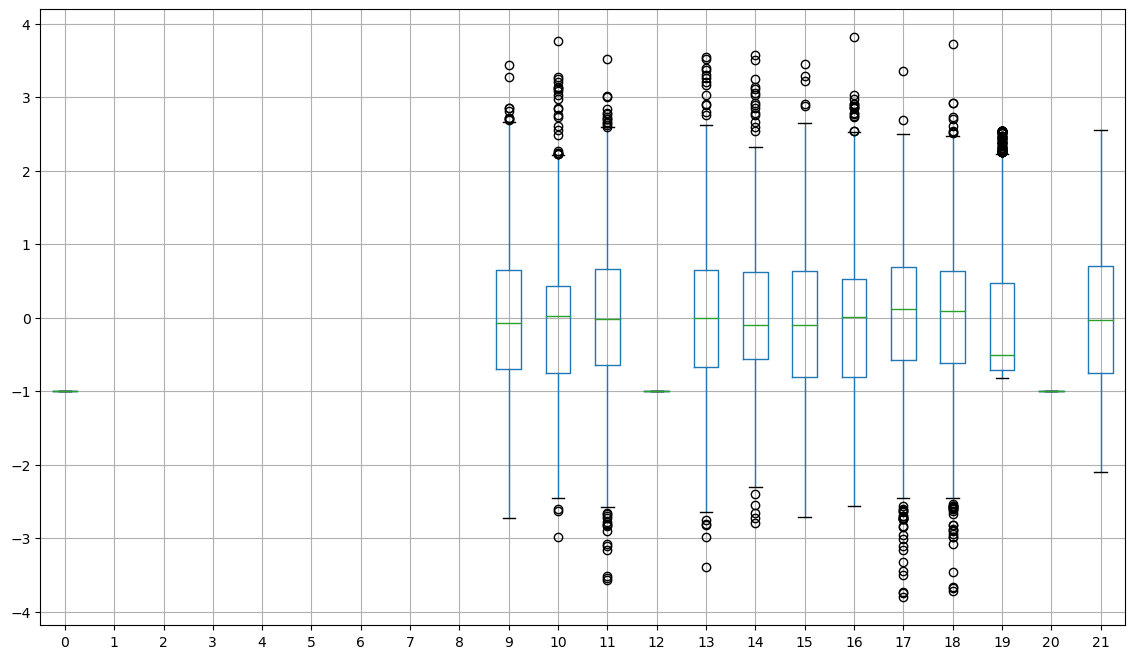

In [7]:
columns_given_0 = [i for i in range(22)]
full_data_df.boxplot(column=columns_given_0, figsize=(14, 8))
plt.show()

### Analysis of the injection pressure dataframe with engineered features

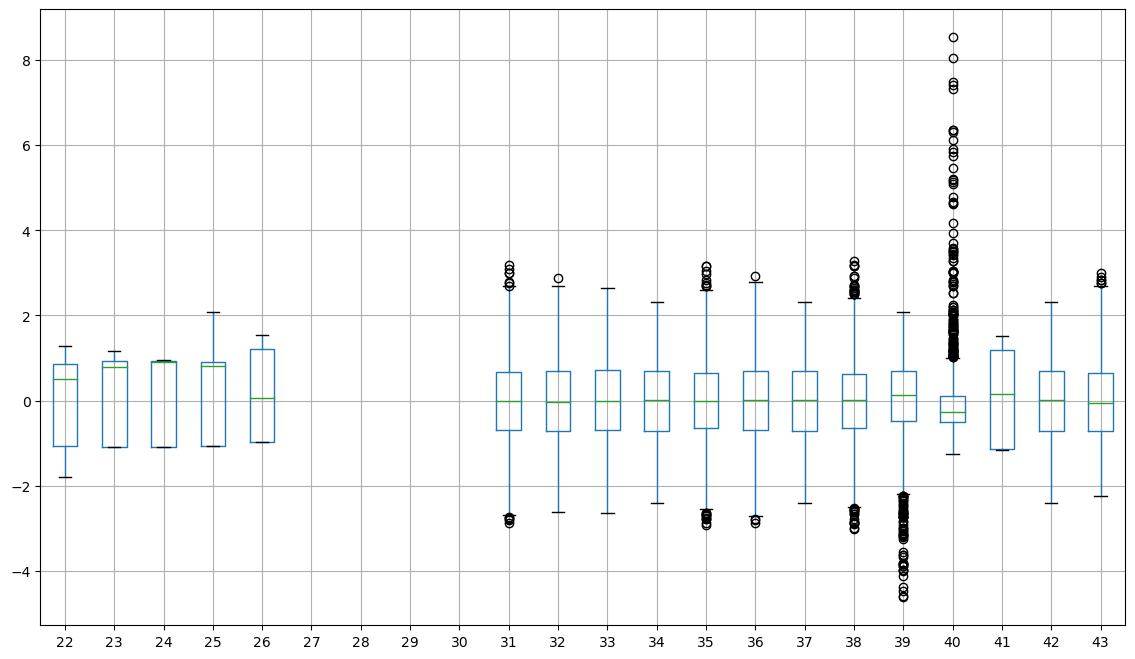

In [8]:
columns_given_1 = [i for i in range(22, 44)]
full_data_df.boxplot(column=columns_given_1, figsize=(14, 8))
plt.show()

### Analysis of the sensor pressure dataframe with engineered features

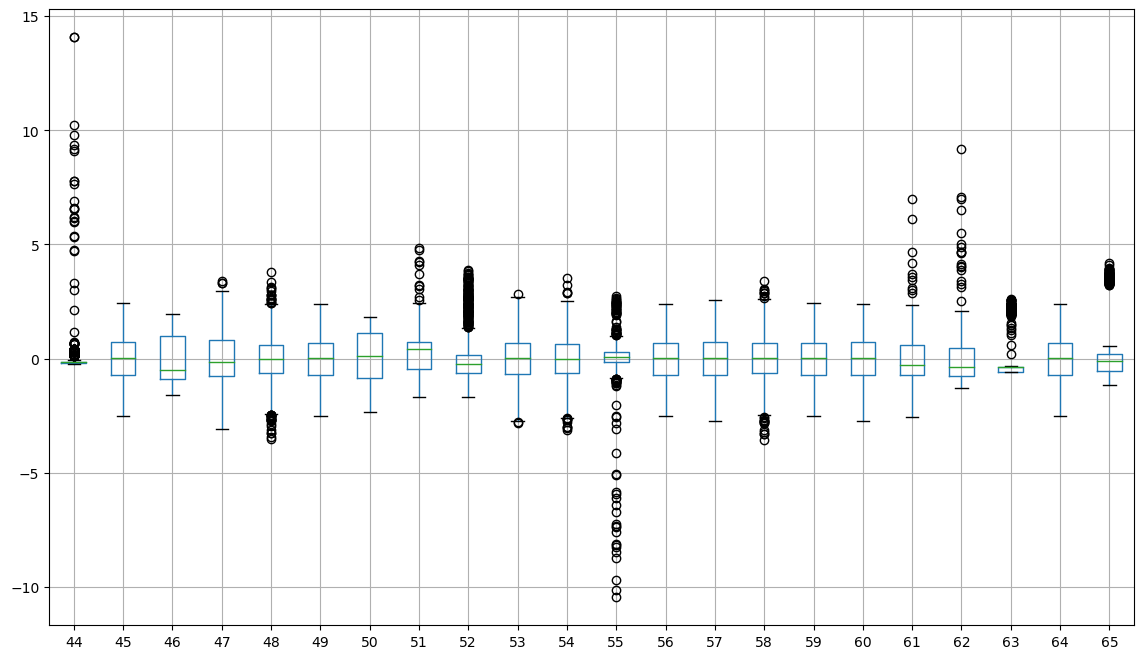

In [9]:
columns_given_2 = [i for i in range(44, 66)]
full_data_df.boxplot(column=columns_given_2, figsize=(14, 8))
plt.show()

In [10]:
# Checking datatypes
full_data_df.dtypes

0     float64
1     float64
2     float64
3     float64
4     float64
       ...   
62    float64
63    float64
64    float64
65    float64
66      int64
Length: 67, dtype: object

In [11]:
# Statistical description
full_data_df.describe()

,0,1,2,3,4,5,6,7,8,9,...,57,58,59,60,61,62,63,64,65,66
count,1.542000e+03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.542000e+03,...,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1.542000e+03,1542.000000
mean,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.948233e-14,...,-2.820053e-15,-1.198062e-16,-1.251053e-15,1.760229e-15,-1.271789e-15,4.607930e-16,-9.215859e-17,-1.211885e-15,3.317709e-15,0.700389
std,2.221166e-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.458236
min,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.718529e+00,...,-2.749356e+00,-3.568701e+00,-2.512066e+00,-2.730771e+00,-2.577519e+00,-1.293336e+00,-5.979322e-01,-2.519926e+00,-1.165349e+00,0.000000
25%,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.024125e-01,...,-7.248681e-01,-6.126554e-01,-7.202132e-01,-7.116764e-01,-7.111062e-01,-7.808198e-01,-5.851154e-01,-7.136551e-01,-5.320928e-01,0.000000
50%,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-7.296535e-02,...,1.341570e-02,2.758586e-02,2.299008e-02,1.116590e-02,-2.630358e-01,-3.717274e-01,-3.798319e-01,2.464398e-02,-1.152257e-01,1.000000
75%,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.561977e-01,...,7.145871e-01,6.814970e-01,6.994893e-01,7.253287e-01,5.821131e-01,4.717218e-01,-3.567670e-01,6.970319e-01,1.821477e-01,1.000000
max,-9.996757e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.443609e+00,...,2.571423e+00,3.389021e+00,2.421489e+00,2.402760e+00,6.999047e+00,9.178524e+00,2.608139e+00,2.378413e+00,4.206606e+00,1.000000


#### Prunning Data

In [12]:
full_data_df.dropna(axis=1, inplace=True)
full_data_df.head()

,0,9,10,11,12,13,14,15,16,17,...,57,58,59,60,61,62,63,64,65,66
0,-0.999676,1.501974,1.939444,-0.343346,-0.999676,0.564167,1.715246,1.649904,1.958295,-1.773758,...,1.045017,-0.726272,1.080923,0.919813,1.672058,1.169527,-0.388646,1.087917,0.239571,1
1,-0.999676,-0.518824,-0.486110,0.360816,-0.999676,-0.387596,-0.449908,-0.656303,-0.797283,0.815002,...,-0.800240,-0.584643,-0.892881,-0.827658,-0.972617,-0.902328,-0.588649,-0.931479,0.126121,1
2,-0.999676,-1.548079,-2.029322,-0.295393,-0.999676,-0.073770,-1.500208,-1.993306,-1.710538,1.163351,...,-0.910617,0.666707,-0.887516,-0.780052,-1.196270,-0.673753,-0.356121,-0.896233,0.277676,1
3,-0.999676,-0.443703,-0.014819,-0.403499,-0.999676,0.731069,-0.191695,0.538220,-0.031719,-0.341763,...,-0.086129,-1.057934,-0.249751,-0.224066,-0.553176,-0.916950,-0.587298,-0.323358,0.338197,1
4,-0.999676,-0.269275,0.172989,-0.852749,-0.999676,0.531535,0.056051,-0.141051,0.033288,-0.487708,...,0.489163,0.168318,0.515940,0.468939,0.535320,0.346533,-0.382682,0.509872,-0.586794,1


- The length of the dataset after prunning is:

In [13]:
print(f"The number of datapoints is {len(full_data_df)}")
# we subtract the label from the number of attributes/features
print(f"The number of attributes/features is {len(full_data_df.columns) - 1}")

The number of datapoints is 1542
The number of attributes/features is 54


## Selecting the Machine Learning Model
-  Because were dealing with a classification problem but not a regression, we need to consider models that allows to classify.
- Let's start with:
    1. Decision trees & Ensembles
    2. kNN
    3. SVM
    4. Neural Networks

### Decision Trees & Ensembles
- We will start by using _decision trees_ with bagging (Bootstrap Aggregating). The idea is that using the same model, we will randomly arrange the initial tree configuration and then proceed to calculate the outcome.
- By same model we mean how we split and select the features and how we predict the outcome (simple voting, weighted voting).
- We will use the class RandomForestClassifier which incorporates the methods and attributes when working with a decission tree with bagging.
- **NOTE**: Due to the random initial configuration for the decision trees, this algorithm naturally incorporates cross-validation which can also help with overfitting.
- **TODO**: Constant values on the features are not relevant when splitting. Is it a good idea to drop those features?

- Splitting the data

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data_df.drop([66], axis=1),
    full_data_df[66],
    test_size=0.2)

In [15]:
n = len(full_data_df)
n_train = len(X_train)
n_test = len(X_test)

- The splitting looks as follows:

In [16]:
print(f"The total number of datapoints is: {n}")
print(f"The size of training set is {n_train} which correspond to the {n_train * 100 / n:.2f}%")
print(f"The size of test set is {n_test} which correspond to the {n_test * 100 / n:.2f}%")

The total number of datapoints is: 1542
The size of training set is 1233 which correspond to the 79.96%
The size of test set is 309 which correspond to the 20.04%


#### Tranining Phase

- We create an instance of the Random Forest Classifier (RFC)

In [17]:
pilot_model_rfc = RandomForestClassifier()

- We now train a pilot model:

In [18]:
pilot_model_rfc.fit(X_train, y_train)

RandomForestClassifier()

- It is important to note that in a time series problem the mean accuracy cannot be considered as a good indicator for the performance. The reason for this is that the datapoins are time correlated and are therefore not independent from each other. However, after the feature engineering which allows to represent the time series problem as a classification problem with tabular data, then we at this point can consider the mean accuracy as good indicator for the performance of the algorithm **ONLY** when we have a balanced dataset!. We will address this issue later, for now we will work with mean accuracy.

In [19]:
print(f"The mean accuracy of the model with defaults is: \
{pilot_model_rfc.score(X_test, y_test) * 100:.2f}%")

The mean accuracy of the model with defaults is: 73.14%


- The defaults of this method are:

In [20]:
pilot_model_rfc.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

#### Hyperparameter Optimization
- Now we will explore the effect of some hyperparameters

In [21]:
def rfc_train_evaluator(model_rfc) -> tuple:
    model_rfc.fit(X_train, y_train)
    mean_accuracy = model_rfc.score(X_test, y_test) * 100
    y_predicted = model_rfc.predict(X_test)
    return (mean_accuracy, y_predicted)

- The default number of trees is 100 which can be considered a reasonable good attempt. However, we are now explore lower an higher values to see if we could improve the performance of our model:

In [22]:
accuracy_rfc = []
predictions_rfc = []
n_trees_list = [x for x in range(10, 210, 5)]
# The paths where the files will be saved
accuracy_rfc_path = "./Data/accuracy_rfc.txt"
predictions_rfc_path = "./Data/predictions_rfc.txt"
if update_results:
    print("Generating the accuracy and predictions ...")
    for n_trees in n_trees_list:
        model_rfc = RandomForestClassifier(n_estimators=n_trees)
        accuracy, prediction = rfc_train_evaluator(model_rfc)
        accuracy_rfc.append(round(accuracy, 2))
        predictions_rfc.append(prediction)
    accuracy_rfc = np.array(accuracy_rfc)
    predictions_rfc = np.array(predictions_rfc)
    np.savetxt("./Data/accuracy_rfc.txt", accuracy_rfc)
    np.savetxt("./Data/predictions_rfc.txt", predictions_rfc)
else:
    if not os.path.exists(accuracy_rfc_path) and not os.path.exists(predictions_rfc_path):
        print("Generating the accuracy and predictions ...")
        for n_trees in n_trees_list:
            model_rfc = RandomForestClassifier(n_estimators=n_trees)
            accuracy, prediction = rfc_train_evaluator(model_rfc)
            accuracy_rfc.append(round(accuracy, 2))
            predictions_rfc.append(prediction)
        accuracy_rfc = np.array(accuracy_rfc)
        predictions_rfc = np.array(predictions_rfc)
        np.savetxt("./Data/accuracy_rfc.txt", accuracy_rfc)
        np.savetxt("./Data/predictions_rfc.txt", predictions_rfc)
    else:
        print("Loading accuracy and predictions from disk ...")
        accuracy_rfc = np.loadtxt("./Data/accuracy_rfc.txt")
        predictions_rfc = np.loadtxt("./Data/predictions_rfc.txt").astype(dtype=int)

Loading accuracy and predictions from disk ...


- We know plot to see the effect of the number of trees on the performance of the model:

In [28]:
# we will plot also the running average
window_rfc = 5
rolling_mean_average = []
for index in range(len(accuracy_rfc) - window_rfc + 1):
    rolling_mean_average.append(np.mean(accuracy_rfc[index:index+window_rfc]))
for index in range(window_rfc - 1):
    rolling_mean_average.insert(0, np.nan)

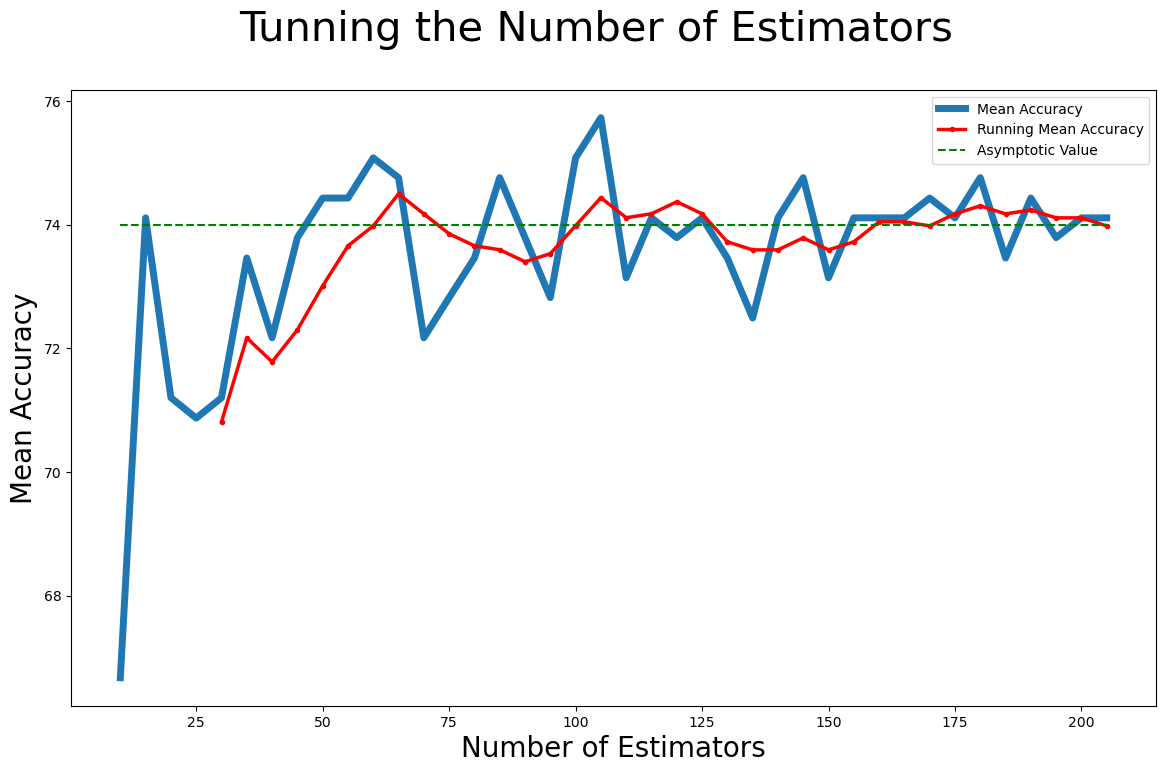

In [39]:
fig_rfc = plt.figure(figsize=[14, 8])
fs = 20  # fontsize
lw = 5  # linewidth
fig_rfc.suptitle("Tunning the Number of Estimators", fontsize=fs * 1.5)
plt.xlabel("Number of Estimators", fontsize=fs)
plt.ylabel("Mean Accuracy", fontsize=fs)
plt.plot(n_trees_list, accuracy_rfc, linewidth=lw, label="Mean Accuracy")
plt.plot(n_trees_list, rolling_mean_average, "r.-", linewidth=0.5*lw, label="Running Mean Accuracy")
plt.hlines(74, min(n_trees_list), max(n_trees_list), color='green', linestyle='dashed', label='Asymptotic Value')
plt.legend()
plt.show()

- From the plot above we can see that the mean accuracy increases with the number of trees (number of estimators). Starting with a number of trees equal to 10 already provides an accuracy close to 70% and this rapidily increases as we increase the number of trees. However, we see that we reach a plateau with middle accuracy of around 74%. Therefore for further explorations on the hyperparameter optimization _we will choose the number of estimators equal to $200$_. Also We can see why the default value is chosen to $100$.

- **IMPORTANT:**
    - The Mean Average have no meaning when the labeling of the data is unbalanced.

In [56]:
# percentage of valid products
pvp_train = np.count_nonzero(y_train)/len(y_train) * 100
print(f"The unbalanced of the training set has:\n {pvp_train:.2f}% of valid products and \
      \n {100 - pvp_train:.2f}& of invalid products")

The unbalanced of the training set has:
 69.67% of valid products and       
 30.33& of invalid products


In [58]:
# percentage of valid products
pvp_test = np.count_nonzero(y_test)/len(y_test) * 100
print(f"The unbalanced of the test set has:\n {pvp_test:.2f}% of valid products and \
      \n {100 - pvp_test:.2f}& of invalid products")

The unbalanced of the test set has:
 71.52% of valid products and       
 28.48& of invalid products
